In [1]:
import lightgbm as lgb

In [544]:
import warnings
import random
import itertools

import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, ttest_ind, binned_statistic
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import scale
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from category_encoders.target_encoder import TargetEncoder
from sklearn.calibration import CalibratedClassifierCV
from plot_metric import functions
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
pd.set_option('max_columns', 50)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [207]:
df_url = '~/Desktop/testing/dodo/data/data.csv'
df = pd.read_csv(df_url, engine='python')

print(df.shape)
df.head()

(20468, 29)


,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,noadditionallines,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,\N,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,3122,624,0,2015,1


Сразу видим, что встретились клиенты младше 18 с высоким годовым доходом и законченным бакалавриатом
В целях нивелирования эффекта от шумных данных, можно подозрительные значения заменить на -1 или добавить флаг на каждую фичу:
    - age < 18
    - annualincome (?)
    - age + 4 < 20 -> not Bachelor
    - age + 6 < 22 -> not Master
    - age + 9 < 25 -> not PhD

# Feature engineering ideas 

# LigtGBM model

## Данные для модели

In [476]:
df_upd = df.copy()
df_upd.drop(columns=['noadditionallines'], inplace=True)

exclude_fs = ['customerid', 'churn', 'year', 'month', 'callingnum']

cat_fs = df_upd.select_dtypes(include=["bool", "object"]).columns.tolist()
num_fs = [col for col in df_upd.select_dtypes(include=["int64", "float64"]).columns.tolist() if col not in exclude_fs]

In [477]:
def all_combinations(any_list):
    return itertools.chain.from_iterable(
        itertools.combinations(any_list, i + 1)
        for i in range(len(any_list)))


for col in cat_fs:
    df_upd[col] = df_upd[col].astype(str)
    
comb = [list(l) for l in all_combinations(cat_fs) if len(l)<=2 and  len(l)>1]

for col in comb:
    new_col = '_'.join(col)
    df_upd[f'{ new_col }'] = df_upd[comb[-1]].apply(lambda x:'_'.join(x), axis=1)

df_upd['f4'] = df.callingnum.astype(str).str[:3]

df_upd['f5'] = 0
df_upd.loc[df_upd.age < 18, 'f5'] = 1

# df_upd['f6'] = df.groupby(['state', 'gender', 'education'])['annualincome'].transform('mean')

df_upd['f7'] = 0
df_upd.loc[(df_upd.age+4 < 20)&(df.education == 'Bachelor or equivalent'), 'f7'] = 1
df_upd.loc[(df_upd.age+6 < 22)&(df.education == 'Master or equivalent'), 'f7'] = 1
df_upd.loc[(df_upd.age+6 < 25)&(df.education == 'PhD or equivalent'), 'f7'] = 1

In [478]:
print(df_upd.shape)
df_upd.head()

(20468, 67)


,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,...,education_usesvoiceservice,gender_homeowner,gender_maritalstatus,gender_occupation,gender_state,gender_usesinternetservice,gender_usesvoiceservice,homeowner_maritalstatus,homeowner_occupation,homeowner_state,homeowner_usesinternetservice,homeowner_usesvoiceservice,maritalstatus_occupation,maritalstatus_state,maritalstatus_usesinternetservice,maritalstatus_usesvoiceservice,occupation_state,occupation_usesinternetservice,occupation_usesvoiceservice,state_usesinternetservice,state_usesvoiceservice,usesinternetservice_usesvoiceservice,f4,f5,f7
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,...,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,425,1,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,...,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,425,1,1
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,...,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,425,0,0
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,...,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,No_Yes,425,0,0
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,3122,624,...,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,No_No,425,0,0


In [483]:
exclude_fs = ['customerid', 'churn', 'year', 'month', 'callingnum']

cat_features = list(set(df_upd.select_dtypes(include=["bool", "object"]).columns.tolist()+['f4', 'f5', 'f7']))
num_features = [col for col in df_upd.select_dtypes(include=["int64", "float64"]).columns.tolist() if col not in exclude_fs+['f4', 'f5', 'f7']]

len(cat_features), len(num_features)

(48, 14)

# LightGBM model

## Параметры и инициализация

In [515]:
params = {
    'params_clf': {
        'max_depth': 2,
        'n_estimators': 175,
        'learning_rate': .3,
        'objective': 'binary',
        'subsample_for_bin': 200,
        'subsample': .7,
        'colsample_bytree': .7,
        'reg_alpha': 1,
        'class_weight': {
            1: df_upd.shape[0]/(2 * df_upd.loc[df_upd.churn == 1, 'churn'].shape[0]),
            0: df_upd.shape[0]/(2 * df_upd.loc[df.churn == 0, 'churn'].shape[0])
        },
        
        'n_jobs': 4,
        'random_state': 42
    },
    'params_skf': {
        'n_splits': 3,
        'shuffle': True,
        'random_state': 42
    }
}


skf = StratifiedKFold(**params['params_skf'])
clf_lgb = lgb.LGBMClassifier(**params['params_clf'])

In [516]:
def plt_roc_auc_curve(y_test, y_probs, y_train, y_train_probs):    
    auc_score = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    auc_score1 = roc_auc_score(y_train, y_train_probs)
    fpr1, tpr1, _ = roc_curve(y_train, y_train_probs)
    
    plt.figure(figsize=(8, 8))
    plt.plot([0,1], [0,1], linestyle='--', label='Random model')
    plt.plot(fpr, tpr, label='Test AUC-ROC curve', color='r');
    plt.plot(fpr1, tpr1, label='Train AUC-ROC curve', color='b');
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    props = {
            'boxstyle': 'round', 
            'facecolor': 'wheat', 
            'alpha': 0.5
            }
    
    plt.text(0.05, 0.95, f'Test AUC-ROC score: { auc_score.round(3) }\nTrain AUC-ROC score: { auc_score1.round(3) }', fontsize=12,
            verticalalignment='top', bbox=props)
    plt.legend(loc='lower right')

In [517]:
def preproc_train_bl(X, y, num_features_list, cat_features_list):
    d = defaultdict(LabelEncoder)
    encoded_cat_features = X[cat_features_list].apply(lambda x: d[x.name].fit_transform(x))
    
    X_p = pd.concat([encoded_cat_features, X[num_features_list]], axis=1, ignore_index=True)
    X_p.columns = cat_features+num_features
    
    return_dict = {
        'X': X_p,
        'y': y,
        'le': {
            i: dict(zip(d[i].classes_, d[i].transform(d[i].classes_))) for i in d.keys()
                }
                  }
    
    return return_dict


def preproc_test_bl(X, num_features_list, cat_features_list, cat_encoder):
    for c in cat_features_list:
        not_seen = set(X[c])-set(cat_encoder[c].keys())
        X[c].replace(not_seen, 10**6, inplace=True)
        X[c].replace(cat_encoder[c], inplace=True)
        
    return X[cat_features_list+num_features_list]

In [518]:
train_months, test_months = [1], [2]
X_train, X_test, y_train, y_test = df_upd[df_upd.month.isin(train_months)], \
    df_upd[df_upd.month.isin(test_months)], \
    df_upd.loc[df_upd.month.isin(train_months), 'churn'], \
    df_upd.loc[df_upd.month.isin(test_months), 'churn']

X_val, y_val = df_upd[df_upd.month == 3], df_upd.loc[df_upd.month == 3, 'churn']

train_data = preproc_train_bl(X_train, y_train, num_features, cat_features)
test_data = preproc_test_bl(X_test, num_features, cat_features, train_data['le'])
val_data = preproc_test_bl(X_val, num_features, cat_features, train_data['le'])

clf_lgb_fitted = clf_lgb.fit(
    train_data['X'], 
    train_data['y'], 
    categorical_feature=[i for i in cat_features]
)

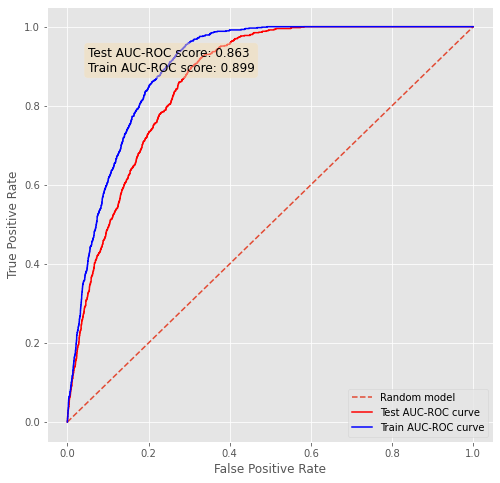

In [519]:
plt_roc_auc_curve(y_test, clf_lgb_fitted.predict_proba(test_data)[:, 1], train_data['y'], clf_lgb_fitted.predict_proba(train_data['X'])[:, 1])

In [520]:
bc = functions.BinaryClassification(
                                    y_test,
                                    clf_lgb_fitted.predict_proba(test_data)[:, 1],
                                    labels=[0,1],
                                    threshold=.5
                            )

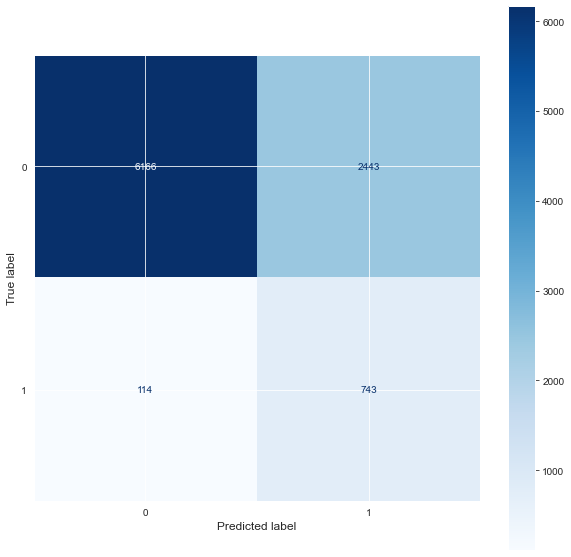

In [521]:
fig, ax = plt.subplots(
    figsize=(10, 10),
)

plot_confusion_matrix(
    clf_lgb_fitted,
    test_data,
    y_test,
    cmap='Blues',
    ax=ax
);

In [523]:
print(metrics.classification_report(
    y_test,
    clf_lgb_fitted.predict_proba(test_data)[:, 1].round(0)
))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      8609
           1       0.23      0.87      0.37       857

    accuracy                           0.73      9466
   macro avg       0.61      0.79      0.60      9466
weighted avg       0.91      0.73      0.79      9466



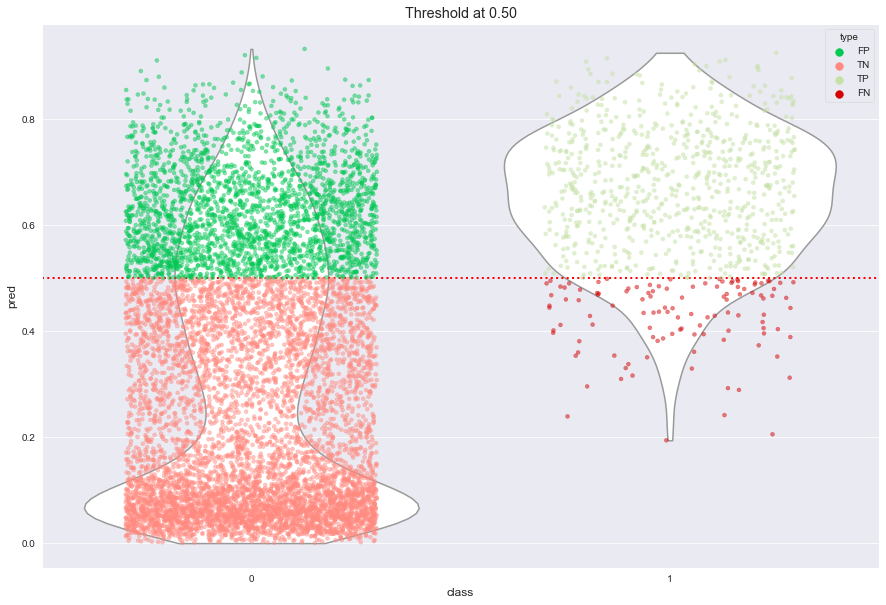

In [524]:
plt.figure(figsize=(15, 10));
bc_class_dit = bc.plot_class_distribution()

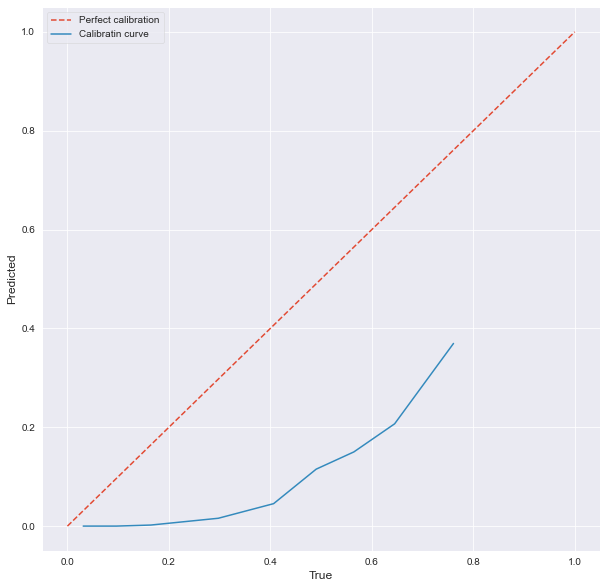

In [527]:
y_means, proba_means = calibration_curve(
    y_test,
    clf_lgb_fitted.predict_proba(test_data)[:, 1],
    n_bins=10, 
    strategy='quantile'
)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Calibratin curve');
plt.xlabel('True');
plt.ylabel('Predicted');
plt.legend();

## Посмотрим на SHAP

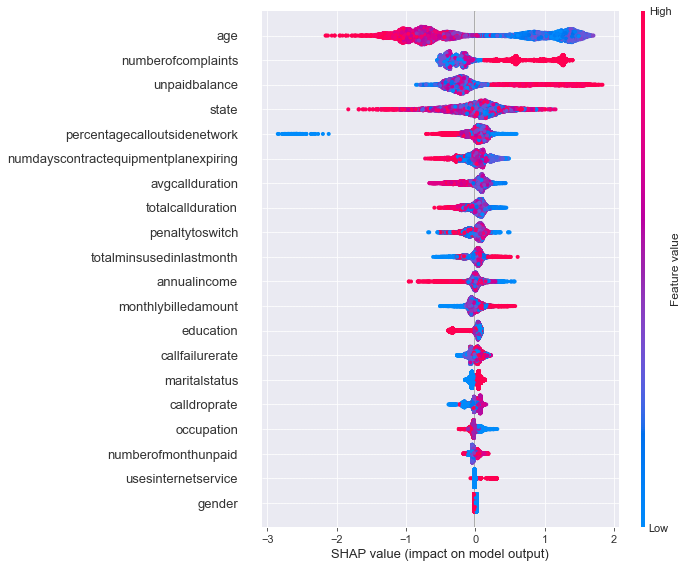

In [528]:
import shap

exp = shap.TreeExplainer(clf_lgb_fitted)
shap_values = exp.shap_values(test_data)
shap.summary_plot(shap_values[1], test_data)

In [529]:
x = pd.DataFrame(np.abs(shap_values[1]))
x.columns = cat_features+num_features
shap_f_importances = x.sum().sort_values(ascending=False)

In [530]:
best_fs = shap_f_importances[shap_f_importances > 0].index

best_fs

Index(['age', 'numberofcomplaints', 'unpaidbalance', 'state',
       'percentagecalloutsidenetwork', 'numdayscontractequipmentplanexpiring',
       'avgcallduration', 'totalcallduration', 'penaltytoswitch',
       'totalminsusedinlastmonth', 'annualincome', 'monthlybilledamount',
       'education', 'callfailurerate', 'maritalstatus', 'calldroprate',
       'occupation', 'numberofmonthunpaid', 'usesinternetservice', 'gender',
       'customersuspended_occupation', 'f5', 'f7', 'homeowner'],
      dtype='object')

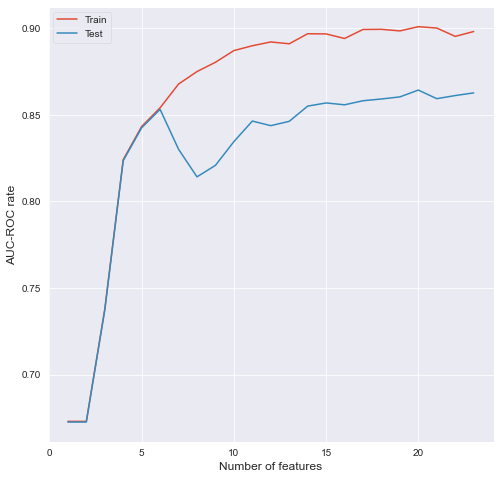

In [531]:
def custom_clf(clf, X, X_test, y, y_test, needed_col, cat_features):

    clf_lgb_fitted = clf.fit(
                    X[needed_col], 
                    y, 
                    categorical_feature=[i for i in cat_features if i in needed_col]
                )
    
    return (
            roc_auc_score(y, clf_lgb_fitted.predict_proba(X[needed_col])[:, 1]), 
            roc_auc_score(y_test, clf_lgb_fitted.predict_proba(X_test[needed_col])[:, 1])
            )
    
selecting_fs = {
    i+1: custom_clf(
            lgb.LGBMClassifier(**params['params_clf']),
            train_data['X'],
            test_data,
            y_train,
            y_test,
            best_fs[:i+1],
            cat_features
    ) for i in range(len(best_fs[1:]))   
}

plt.figure(figsize=(8,8))
plt.plot(selecting_fs.keys(), list(map(lambda x: x[0], list(selecting_fs.values()))), label='Train');
plt.plot(selecting_fs.keys(), list(map(lambda x: x[1], list(selecting_fs.values()))), label='Test');
plt.legend();
plt.xlabel('Number of features');
plt.ylabel('AUC-ROC rate');

In [533]:
selecting_fs[5], selecting_fs[6], selecting_fs[7]

((0.843279504745547, 0.8425547983555783),
 (0.8540869688028948, 0.8531851080380047),
 (0.8678079454975044, 0.8301633537831091))

# Small features

In [538]:
clf_lgb_new = lgb.LGBMClassifier(**params['params_clf'])
clf_lgb_fitted_s = clf_lgb_new.fit(
    train_data['X'][best_fs[:6]], 
    train_data['y'], 
    categorical_feature=[i for i in cat_features if i in best_fs[:6]]
)

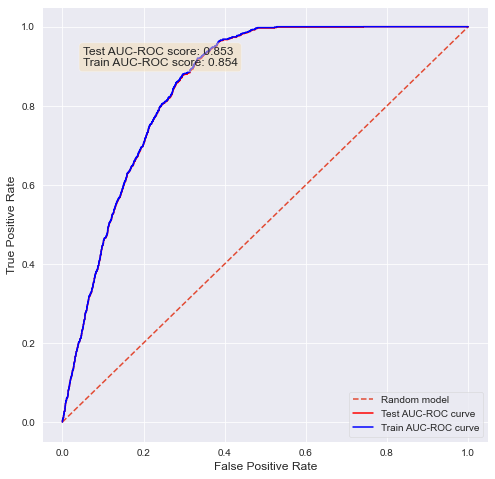

In [539]:
plt_roc_auc_curve(
    y_test,
    clf_lgb_fitted_s.predict_proba(test_data[best_fs[:6]])[:, 1], 
    train_data['y'], 
    clf_lgb_fitted_s.predict_proba(train_data['X'][best_fs[:6]])[:, 1]
)

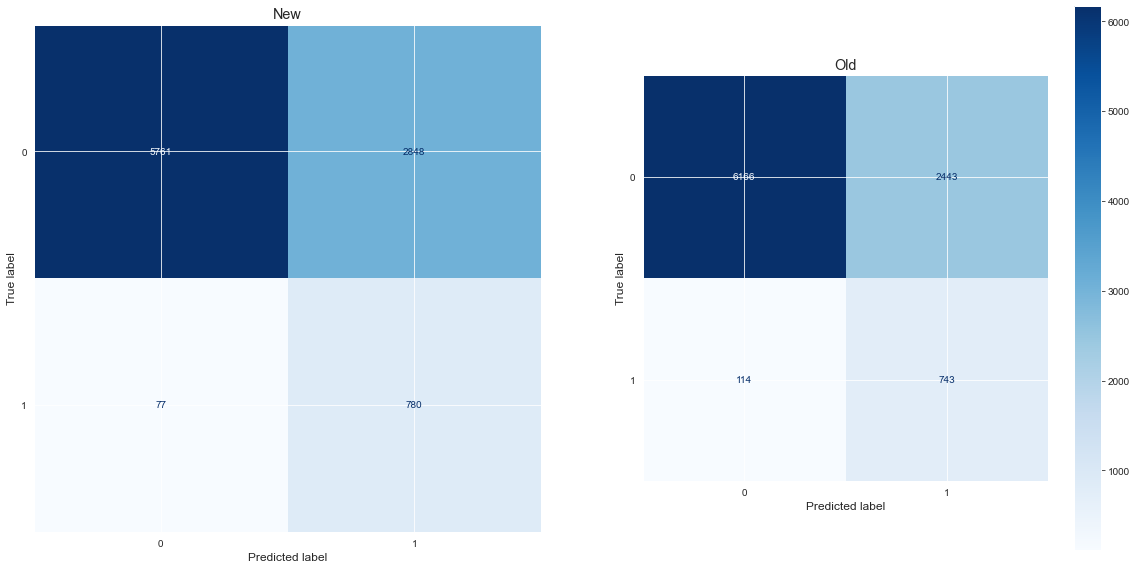

In [541]:
fig, axes = plt.subplots(
    1,2,
    figsize=(20, 10),
)


plot_confusion_matrix(
    clf_lgb_fitted_s,
    test_data[best_fs[:6]],
    y_test,
    cmap='Blues',
    ax=axes[0],
    colorbar=False
);
axes[0].set_title('New');

plot_confusion_matrix(
    clf_lgb_fitted,
    test_data,
    y_test,
    cmap='Blues',
    ax=axes[1]
);
axes[1].set_title('Old');

In [542]:
print(metrics.classification_report(
    y_test,
    clf_lgb_fitted_s.predict_proba(test_data[best_fs[:6]])[:, 1].round(0)
),
      '\n',
    metrics.classification_report(
    y_test,
    clf_lgb_fitted.predict_proba(test_data)[:, 1].round(0)
) 
     )

              precision    recall  f1-score   support

           0       0.99      0.67      0.80      8609
           1       0.21      0.91      0.35       857

    accuracy                           0.69      9466
   macro avg       0.60      0.79      0.57      9466
weighted avg       0.92      0.69      0.76      9466
 
               precision    recall  f1-score   support

           0       0.98      0.72      0.83      8609
           1       0.23      0.87      0.37       857

    accuracy                           0.73      9466
   macro avg       0.61      0.79      0.60      9466
weighted avg       0.91      0.73      0.79      9466



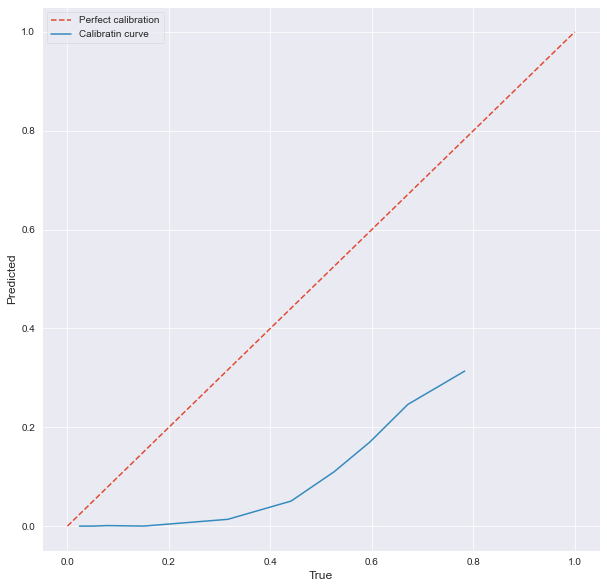

In [545]:
y_means, proba_means = calibration_curve(
    y_test,
    clf_lgb_fitted_s.predict_proba(test_data[best_fs[:6]])[:, 1],
    n_bins=10, 
    strategy='quantile')

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Calibratin curve');
plt.xlabel('True');
plt.ylabel('Predicted');
plt.legend();

In [546]:
calibrated_clf = CalibratedClassifierCV(
    clf_lgb_fitted_s,
    'sigmoid'
)

calibrated_clf.fit(
    train_data['X'][best_fs[:6]], 
    train_data['y']
)

CalibratedClassifierCV(base_estimator=LGBMClassifier(class_weight={0: 0.550067186240258,
                                                                   1: 5.493290391841117},
                                                     colsample_bytree=0.7,
                                                     learning_rate=0.3,
                                                     max_depth=2,
                                                     n_estimators=175, n_jobs=4,
                                                     objective='binary',
                                                     random_state=42,
                                                     reg_alpha=1, subsample=0.7,
                                                     subsample_for_bin=200))

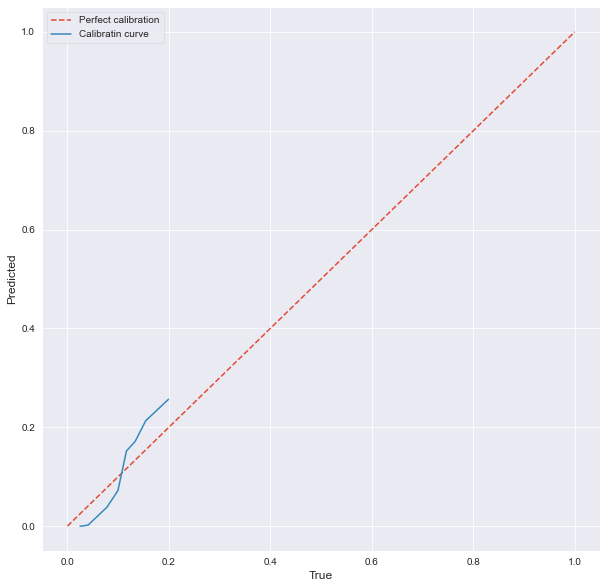

In [551]:
y_means, proba_means = calibration_curve(
    y_test,
    calibrated_clf.predict_proba(test_data[best_fs[:6]])[:, 1],
    n_bins=10, 
    strategy='quantile')

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Calibratin curve');
plt.xlabel('True');
plt.ylabel('Predicted');
plt.legend();

# Эксперимент

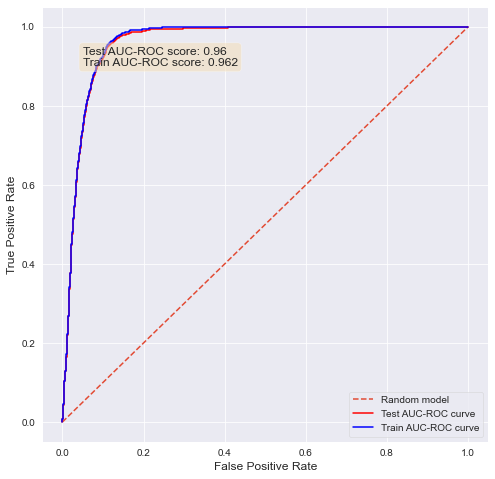

In [549]:
params_t = params['params_clf'].copy()
params_t['n_estimators'] = 2000

clf_lgb_t = lgb.LGBMClassifier(**params_t)

clf_lgb_fitted_t = clf_lgb_t.fit(
    train_data['X'][best_fs[:6]], 
    train_data['y'], 
    categorical_feature=[i for i in cat_features if i in best_fs[:6]]
)

plt_roc_auc_curve(
    y_test, 
    clf_lgb_fitted_t.predict_proba(test_data[best_fs[:6]])[:, 1], 
    train_data['y'], 
    clf_lgb_fitted_t.predict_proba(train_data['X'][best_fs[:6]])[:, 1]
)

In [550]:
best_fs[:6]

Index(['age', 'numberofcomplaints', 'unpaidbalance', 'state',
       'percentagecalloutsidenetwork', 'numdayscontractequipmentplanexpiring'],
      dtype='object')

# Выводы

Ни одна из моделей не будет работать хорошо в проде.
В случае с взятием уникальных клиентов не хватает информативных фичей, а в случае с взятием месяца на обучение и месяца на тест (что выглядит наилучшей стратегией), получаем идентичные объекты (с незначительным добавлением новых) в трейне и тесте

Что можно было бы сделать еще:
- побольше посидеть с континуус фичами (но картину это сильно не поменяет)
- попробовать взять уникальных клиентов от месяц к месяцу (уникальные клиенты в месяце n, затем вновь пришедшие в n+1 и тд)
- убрать шумные объекты
- убрать пользовательские функции в импортируемый модуль
- переработать код с целью оптимизации скорости (напр. поменять некоторые list'ы на set'ы)

Что необходимо для рабочей модели:
- добавить не статичных фичей, меняющихся от месяца к месяцу (агрегаты по континуус фичам за n предыдущих месяцев, транзакционные фичи и тд)
- переопределить таргет
- поисследовать шум в данных (выявить причины)